In [ ]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gopalbhattrai/pascal-voc-2012-dataset


import zipfile
with zipfile.ZipFile('/content/pascal-voc-2012-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')


Dataset URL: https://www.kaggle.com/datasets/gopalbhattrai/pascal-voc-2012-dataset
License(s): unknown
100% 3.52G/3.52G [02:01<00:00, 29.0MB/s]
100% 3.52G/3.52G [02:01<00:00, 31.2MB/s]


In [ ]:
!pip install torch torchvision
!pip install albumentations

In [ ]:
import torch
import torchvision
from torchvision import transforms
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.ssd import ssd300_vgg16

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = ssd300_vgg16(pretrained=True)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:00<00:00, 153MB/s]


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
!ls /content

drive  kaggle.json  pascal-voc-2012-dataset.zip  sample_data  VOC2012_test  VOC2012_train_val


In [ ]:
!ls /content/VOC2012_train_val/VOC2012_train_val/


Annotations  devkit_doc.pdf  ImageSets	JPEGImages  SegmentationClass  SegmentationObject


In [ ]:
!ls /content/VOC2012_train_val/VOC2012_train_val/ImageSets/Main

aeroplane_train.txt	bus_trainval.txt	  diningtable_val.txt	    sheep_train.txt
aeroplane_trainval.txt	bus_val.txt		  dog_train.txt		    sheep_trainval.txt
aeroplane_val.txt	car_train.txt		  dog_trainval.txt	    sheep_val.txt
bicycle_train.txt	car_trainval.txt	  dog_val.txt		    sofa_train.txt
bicycle_trainval.txt	car_val.txt		  horse_train.txt	    sofa_trainval.txt
bicycle_val.txt		cat_train.txt		  horse_trainval.txt	    sofa_val.txt
bird_train.txt		cat_trainval.txt	  horse_val.txt		    train_train.txt
bird_trainval.txt	cat_val.txt		  motorbike_train.txt	    train_trainval.txt
bird_val.txt		chair_train.txt		  motorbike_trainval.txt    train.txt
boat_train.txt		chair_trainval.txt	  motorbike_val.txt	    train_val.txt
boat_trainval.txt	chair_val.txt		  person_train.txt	    trainval.txt
boat_val.txt		cow_train.txt		  person_trainval.txt	    tvmonitor_train.txt
bottle_train.txt	cow_trainval.txt	  person_val.txt	    tvmonitor_trainval.txt
bottle_trainval.txt	cow_val.txt		  pottedplant_train

In [ ]:
import torch
import torchvision
import torch.optim as optim
from torchvision.models.detection import SSD300_VGG16_Weights
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import os
from PIL import Image
import xml.etree.ElementTree as ET


class PascalVOCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'JPEGImages')
        self.annotations_dir = os.path.join(root_dir, 'Annotations')
        self.image_ids = [f[:-4] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f'{image_id}.jpg')
        ann_path = os.path.join(self.annotations_dir, f'{image_id}.xml')

        img = Image.open(img_path).convert("RGB")
        boxes, labels = self.parse_voc_annotation(ann_path)

        if self.transform:
            img = self.transform(img)

        target = {'boxes': boxes, 'labels': labels}
        return img, target

    def parse_voc_annotation(self, ann_path):
        tree = ET.parse(ann_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)

        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.int64)

        return boxes_tensor, labels_tensor

# Transformations
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

# Dataset and DataLoader
dataset = PascalVOCDataset(root_dir='/content/VOC2012_train_val/VOC2012_train_val', transform=transform)
subset_size = int(0.5 * len(dataset))  # Reduce dataset size
dataset, _ = random_split(dataset, [subset_size, len(dataset) - subset_size])

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

# Model Initialization
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torchvision.models.detection.ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
model.to(device)

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)


In [ ]:
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, targets in dataloader:
        # Move images and targets to the device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        # Forward pass and calculate loss
        loss_dict = model(images, targets)  # Loss is returned as a dictionary
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    # Calculate the average loss
    average_loss = running_loss / len(dataloader)
    return average_loss


In [ ]:
def evaluate(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            # Move data to the device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass (returns predictions in eval mode)
            predictions = model(images)

            # Store predictions and labels for metrics calculation
            all_predictions.append(predictions)
            all_labels.append(targets)

    return all_predictions, all_labels


In [ ]:
def compute_iou(box1, box2):
    # Calculate intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate union
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection

    # Compute IoU
    iou = intersection / union if union > 0 else 0
    return iou


In [ ]:
def evaluate_with_accuracy(model, dataloader, device, iou_threshold=0.5):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            predictions = model(images)

            # For each image, compare predictions with targets
            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes'].cpu().numpy()
                target_boxes = target['boxes'].cpu().numpy()

                matched = 0
                for gt_box in target_boxes:
                    for pred_box in pred_boxes:
                        iou = compute_iou(gt_box, pred_box)
                        if iou > iou_threshold:
                            matched += 1
                            break  # Only one prediction can match a ground truth box

                correct += matched
                total += len(target_boxes)

    accuracy = correct / total if total > 0 else 0
    return accuracy


In [ ]:
num_epochs = 20
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, dataloader, optimizer, device)

    accuracy = evaluate_with_accuracy(model, dataloader, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

Epoch 1/20
Training Loss: 6.92
Accuracy: 0.36
Epoch 2/20
Training Loss: 6.61
Accuracy: 0.39
Epoch 3/20
Training Loss: 6.41
Accuracy: 0.40
Epoch 4/20
Training Loss: 6.12
Accuracy: 0.42
Epoch 5/20
Training Loss: 5.82
Accuracy: 0.42
Epoch 6/20
Training Loss: 5.61
Accuracy: 0.42
Epoch 7/20
Training Loss: 5.47
Accuracy: 0.45
Epoch 8/20
Training Loss: 5.20
Accuracy: 0.46
Epoch 9/20
Training Loss: 4.93
Accuracy: 0.46
Epoch 10/20
Training Loss: 4.79
Accuracy: 0.46
Epoch 11/20
Training Loss: 4.84
Accuracy: 0.46
Epoch 12/20
Training Loss: 4.93
Accuracy: 0.40
Epoch 13/20
Training Loss: 5.35
Accuracy: 0.47
Epoch 14/20
Training Loss: 4.50
Accuracy: 0.49
Epoch 15/20
Training Loss: 4.28
Accuracy: 0.50
Epoch 16/20
Training Loss: 4.11
Accuracy: 0.50
Epoch 17/20
Training Loss: 3.95
Accuracy: 0.51
Epoch 18/20
Training Loss: 3.81
Accuracy: 0.51
Epoch 19/20
Training Loss: 3.76
Accuracy: 0.49
Epoch 20/20
Training Loss: 3.83
Accuracy: 0.51


In [ ]:
torch.save(model.state_dict(), "ssd300_voc_weights.pth")


In [ ]:
train_losses = [6.92,6.61,6.41,6.12,5.82,5.61,5.47,5.20,4.93,4.79,4.84,4.93,5.35,4.50,4.28,4.11,3.95,3.81,3.76,3.83]
accuracies = [0.36,0.39,0.40,0.42,0.42,0.42,0.45,0.46,0.46,0.46,0.46,0.40,0.47,0.49,0.50,0.50,0.51,0.51,0.49,0.51]
num_epochs = 20


In [ ]:
train_losses = []
accuracies = []
num_epochs = 5

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss = train_one_epoch(model, dataloader, optimizer, device)
    train_losses.append(train_loss)

    # Evaluate after every epoch
    accuracy = evaluate_with_accuracy(model, dataloader, device)
    accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}")


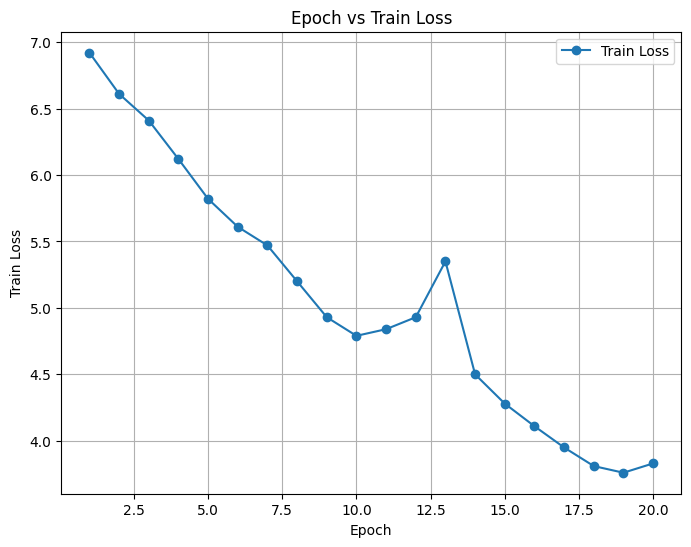

In [ ]:
import matplotlib.pyplot as plt

# Plot Epoch vs Train Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
plt.title('Epoch vs Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.grid(True)
plt.legend()
plt.show()


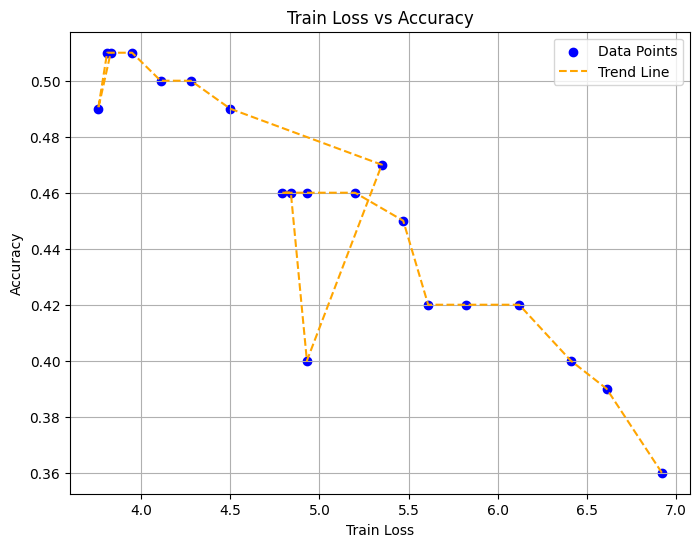

In [ ]:
# Plot Train Loss vs Accuracy
plt.figure(figsize=(8, 6))
plt.scatter(train_losses, accuracies, color='blue', label='Data Points')
plt.plot(train_losses, accuracies, linestyle='--', color='orange', label='Trend Line')
plt.title('Train Loss vs Accuracy')
plt.xlabel('Train Loss')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()


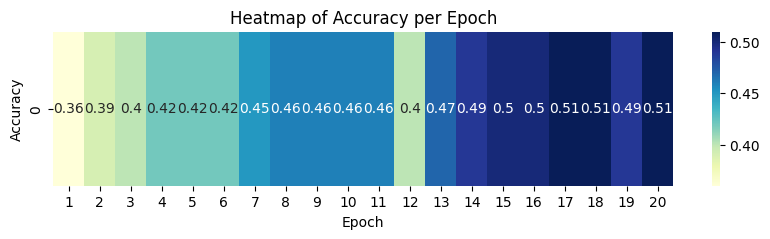

In [ ]:
import seaborn as sns
import numpy as np

# Create a matrix for the heatmap
heatmap_data = np.array(accuracies).reshape(1, -1)  # Reshape into a single row

# Plot heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', cbar=True, xticklabels=range(1, num_epochs + 1))
plt.title('Heatmap of Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


Training complete. Plotting results...


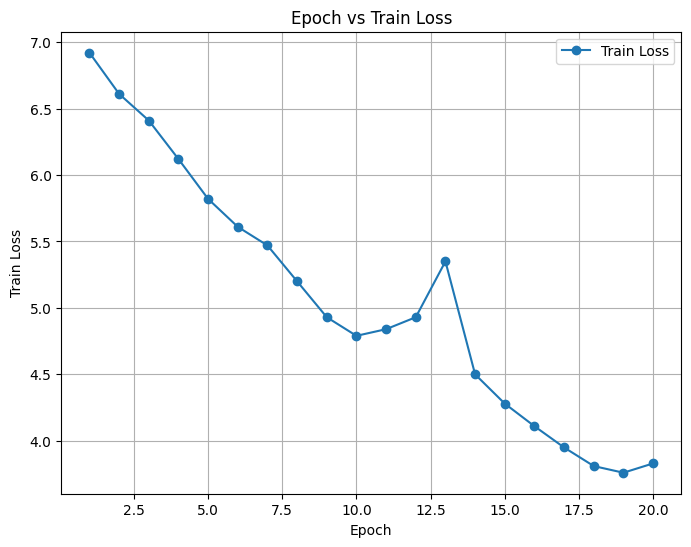

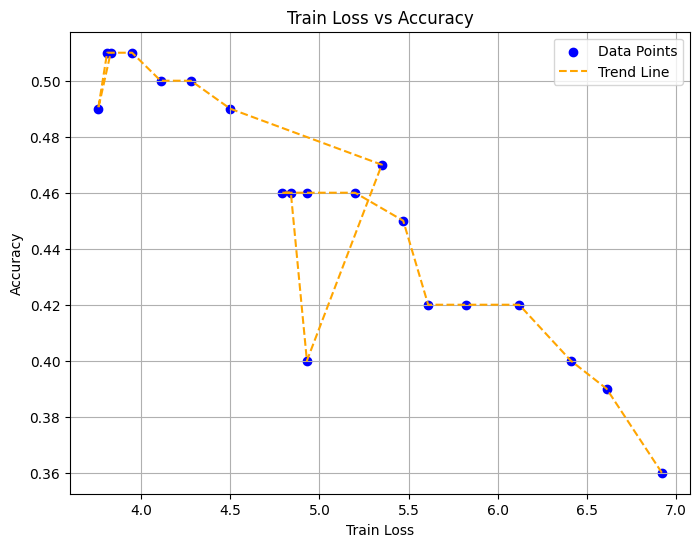

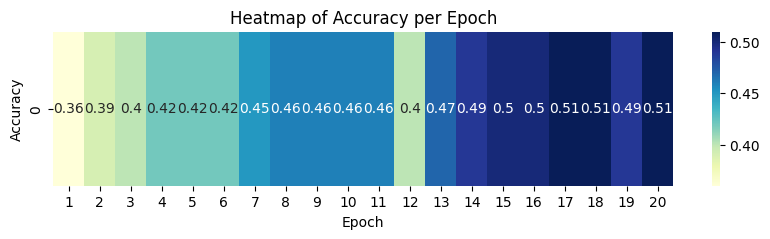

In [ ]:
# After training is complete
print("Training complete. Plotting results...")

# Epoch vs Train Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Train Loss')
plt.title('Epoch vs Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.grid(True)
plt.legend()
plt.show()

# Train Loss vs Accuracy
plt.figure(figsize=(8, 6))
plt.scatter(train_losses, accuracies, color='blue', label='Data Points')
plt.plot(train_losses, accuracies, linestyle='--', color='orange', label='Trend Line')
plt.title('Train Loss vs Accuracy')
plt.xlabel('Train Loss')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(np.array(accuracies).reshape(1, -1), annot=True, cmap='YlGnBu', cbar=True, xticklabels=range(1, num_epochs + 1))
plt.title('Heatmap of Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
print(next(model.parameters()).dtype)


torch.float32


In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def load_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Load image and convert to RGB
    return image
def preprocess_image(image, target_size=(800, 800)):
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Example normalization
    ])
    return transform(image).unsqueeze(0)
def predict(model, image, device):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        image = image.to(device)  # Move image to the same device as the model
        outputs = model(image)  # Forward pass
    return outputs
import matplotlib.pyplot as plt

def visualize_prediction(image, outputs):
    plt.figure(figsize=(12, 8))
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())

    for box in outputs[0]['boxes']:
        plt.gca().add_patch(plt.Rectangle((box[0].item(), box[1].item()),
                                            box[2].item() - box[0].item(),
                                            box[3].item() - box[1].item(),
                                            fill=False, color='red', linewidth=2))

    plt.axis('off')
    plt.show()

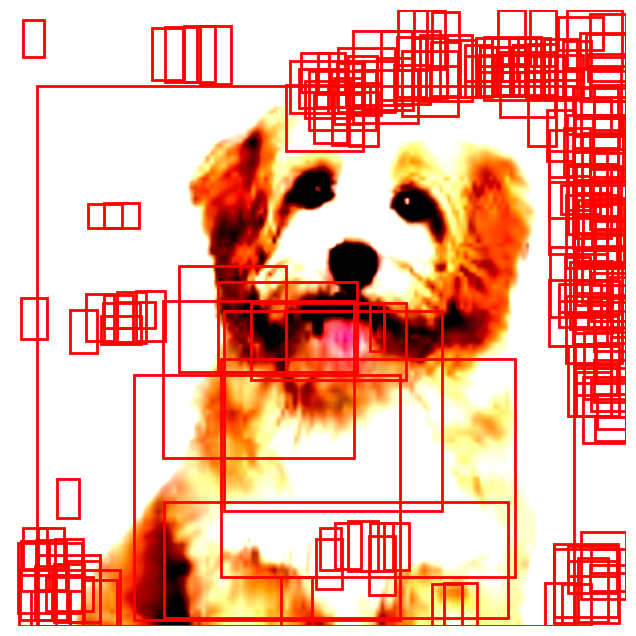

In [ ]:
def main(image_path, model, device):
    # Load and preprocess the image
    image = load_image(image_path)
    preprocessed_image = preprocess_image(image)

    # Make predictions
    outputs = predict(model, preprocessed_image, device)

    # Visualize the prediction
    visualize_prediction(preprocessed_image.squeeze(0), outputs)  # Remove batch dimension for visualization

# Example usage
image_path = "/content/doggg.jpeg"  # Replace with your image path
main(image_path, model, device)


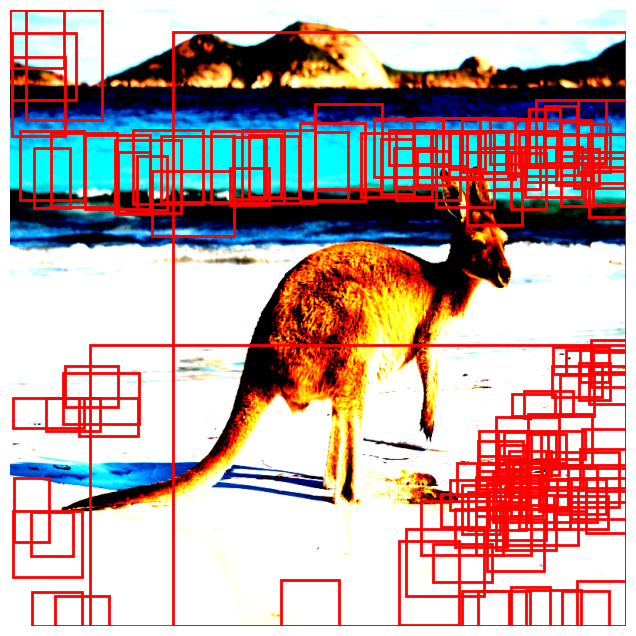

In [ ]:
def main(image_path, model, device):
    # Load and preprocess the image
    image = load_image(image_path)
    preprocessed_image = preprocess_image(image)

    # Make predictions
    outputs = predict(model, preprocessed_image, device)

    # Visualize the prediction
    visualize_prediction(preprocessed_image.squeeze(0), outputs)  # Remove batch dimension for visualization

# Example usage
image_path = "/content/Screenshot 2024-04-13 194949.png"  # Replace with your image path
main(image_path, model, device)
